In [1]:
%matplotlib inline

from collections import namedtuple
from math import degrees

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ephem
import matplotlib.pyplot as plt


philly = ephem.Observer()
philly.lon, philly.lat = '-75.16961', '39.92435'

portland = ephem.Observer()
portland.lon, portland.lat = '-122.68092', '45.50901'

fo_29 = ephem.readtle(
    "JAS-2 (FO-29)",
    "1 24278U 96046B   19132.42991715  .00000011  00000-0  48833-4 0  9994",
    "2 24278  98.5319 290.9039 0349934 336.8182  21.7496 13.53090691122769",
)

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m', facecolor="none")
countries = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m', facecolor="none")
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', facecolor="none")

In [2]:
philly.date = '2019/5/12'
portland.date = '2019/5/12'

def next_n_passses(location, sat, n):
    passes = []
    for i in range(n):
        info = location.next_pass(sat)
        passes.append((info[0], info[4], info[3]))
        location.date = info[4] + 0.01
    return passes

philly_passes = next_n_passses(philly, fo_29, 20)
portland_passes = next_n_passses(portland, fo_29, 20)

best_overlap = {"score": 10000}
for o_rise, o_set, o_max in philly_passes:
    for t_rise, t_set, t_max in portland_passes:
        if t_rise < o_set and t_set > o_rise:
            score = abs(o_max - t_max)
            if best_overlap["score"] > score:
                best_overlap = {
                    "score": score,
                    "rise": o_rise
                }

In [3]:
Point = namedtuple('Point', 'lat lon t')
ground_track = Point([], [], 0)
for i in range(300):
    t = best_overlap['rise'] - 0.01 + i/10000.0
    fo_29.compute(t)
    ground_track.lat.append(degrees(fo_29.sublat))
    ground_track.lon.append(degrees(fo_29.sublong))

def dt(t):
    return t.datetime().strftime(" %H:%M:%S")

begin = best_overlap['rise'] - 0.01
philly.date = begin
philly_pass = philly.next_pass(fo_29)
fo_29.compute(philly_pass[0])
philly_aos = Point(degrees(fo_29.sublat), degrees(fo_29.sublong), dt(philly_pass[0]))

fo_29.compute(philly_pass[2])
philly_max = Point(degrees(fo_29.sublat), degrees(fo_29.sublong), dt(philly_pass[2]))

fo_29.compute(philly_pass[4])
philly_los = Point(degrees(fo_29.sublat), degrees(fo_29.sublong), dt(philly_pass[4]))


portland.date = begin
portland_pass = portland.next_pass(fo_29)
fo_29.compute(portland_pass[0])
portland_aos = Point(degrees(fo_29.sublat), degrees(fo_29.sublong), dt(portland_pass[0]))

fo_29.compute(portland_pass[2])
portland_max = Point(degrees(fo_29.sublat), degrees(fo_29.sublong), dt(portland_pass[2]))

fo_29.compute(portland_pass[4])
portland_los = Point(degrees(fo_29.sublat), degrees(fo_29.sublong), dt(portland_pass[4]))

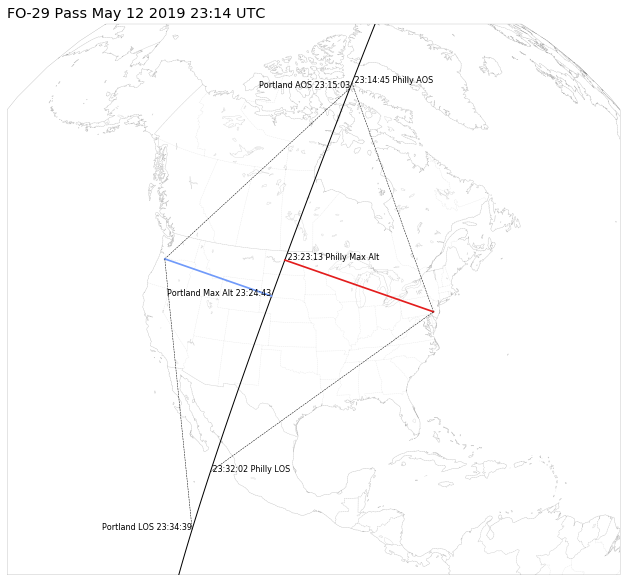

In [4]:
proj = ccrs.NearsidePerspective(
    central_longitude=-95,
    central_latitude=35,
)
geodetic = ccrs.Geodetic()

fig = plt.figure(figsize=(11, 8.5))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9], projection=proj)
ax.set_extent([-140, -50, 5, 85], ccrs.Geodetic())

plt.title("FO-29 Pass {d}".format(d=best_overlap['rise'].datetime().strftime("%b %d %Y %H:%M UTC")), loc='left')
ax.coastlines(resolution='50m', color="grey", linewidth=0.4, alpha=0.3)
ax.add_feature(lakes, edgecolor="grey", linewidth=0.4, alpha=0.3)
ax.add_feature(states, edgecolor="grey", linewidth=0.4, alpha=0.2, dashes='--')
ax.add_feature(countries, edgecolor="grey", linewidth=0.4, alpha=0.3, dashes='--')


ax.plot(ground_track.lon, ground_track.lat, 'k', lw=1, alpha=1, transform=geodetic)
ax.plot([degrees(philly.lon), philly_aos.lon], [degrees(philly.lat), philly_aos.lat], 'k--', lw=0.5, transform=geodetic)
ax.plot([degrees(philly.lon), philly_max.lon], [degrees(philly.lat), philly_max.lat], transform=geodetic)
ax.plot([degrees(philly.lon), philly_los.lon], [degrees(philly.lat), philly_los.lat], 'k--', lw=0.5, transform=geodetic)

ax.plot([degrees(portland.lon), portland_aos.lon], [degrees(portland.lat), portland_aos.lat], 'k--', lw=0.5, transform=geodetic)
ax.plot([degrees(portland.lon), portland_max.lon], [degrees(portland.lat), portland_max.lat], transform=geodetic)
ax.plot([degrees(portland.lon), portland_los.lon], [degrees(portland.lat), portland_los.lat], 'k--', lw=0.5, transform=geodetic)

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
ax.text(philly_aos.lon, philly_aos.lat, philly_aos.t + " Philly AOS", fontsize=8, horizontalalignment='left', transform=geodetic_transform)
ax.text(philly_max.lon, philly_max.lat, philly_max.t + " Philly Max Alt", fontsize=8, horizontalalignment='left', transform=geodetic_transform)
ax.text(philly_los.lon, philly_los.lat, philly_los.t + " Philly LOS", fontsize=8, horizontalalignment='left', transform=geodetic_transform)

ax.text(portland_aos.lon, portland_aos.lat, "Portland AOS" + portland_aos.t, fontsize=8, horizontalalignment='right', transform=geodetic_transform)
ax.text(portland_max.lon, portland_max.lat, "Portland Max Alt" + portland_max.t, fontsize=8, horizontalalignment='right', transform=geodetic_transform)
ax.text(portland_los.lon, portland_los.lat, "Portland LOS" + portland_los.t, fontsize=8, horizontalalignment='right', transform=geodetic_transform)


plt.savefig("map.png", dpi=190)
plt.show()